# Audio signal processing

In [9]:
import numpy as np #scientific library
import scipy #scientific library
import scipy.io.wavfile
import sys, os #file reading, directory parsing routines
import matplotlib #to plot
import matplotlib.pyplot as plt

### Audio file reading 

(132299, 2)


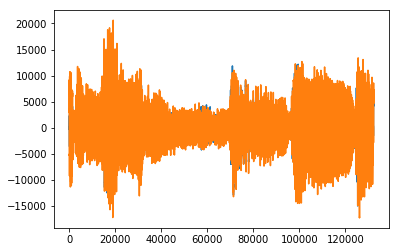

In [10]:
path_to_irmas = '/Users/mariusmiron/Desktop/pydata2017bcn/IRMAS-Sample/'

#read audio file
audio_file = '001__[vio][nod][cou_fol]2194__1.wav'
sampleRate, audioObj = scipy.io.wavfile.read(os.path.join(path_to_irmas,'Training','vio',audio_file)) 

print audioObj.shape
plt.plot(audioObj)
plt.show()

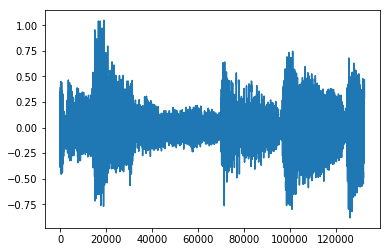

In [11]:
import util

audio, sampleRate, bitrate = util.readAudioScipy(os.path.join(path_to_irmas,'Training','vio',audio_file)) 

plt.plot(audio.sum(axis=1))
plt.show()

### Feature computation

In [12]:
import transform

spectrogram = transform.stft_norm(audio.sum(axis=1), window=np.hanning(1024), hopsize=512, nfft=1024, fs=float(sampleRate))

spectrogram.shape 


(261, 513)

In [13]:
print spectrogram[0,0]
mag = np.abs(spectrogram)
print mag[0,0]

mag = mag  / np.sqrt(1024) #normalization
mag.shape

(7.34953326163+0j)
7.34953326163


(261, 513)

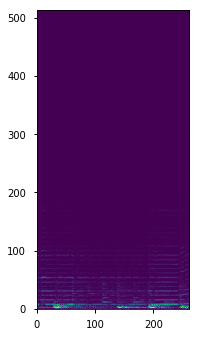

In [14]:
#print plt.style.available
plt.style.use('seaborn-notebook')
plt.imshow(np.log10(1+mag).T,interpolation='none', origin='lower')
plt.show()

In [15]:

mel_basis = transform.mel(sampleRate, n_fft=1024, n_mels=48, fmin=0, fmax=float(sampleRate)/2, htk=False,norm=1)
mel_basis.shape      

(48, 513)

In [16]:
melspec = np.dot(mel_basis, mag.T)
melspec.shape

(48, 261)

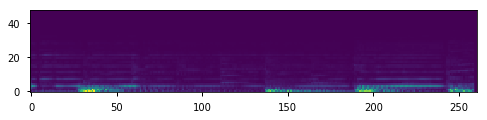

In [17]:
plt.imshow(np.log10(1+melspec),interpolation='none', origin='lower')
plt.show()

In [23]:
feature_dir = os.path.join(path_to_irmas,'features')
if not os.path.exists(feature_dir):
    os.makedirs(feature_dir)

#save the features to file
melspec.tofile(os.path.join(feature_dir,audio_file.replace('.wav','.data')))
#load the features from file
melspecin = np.fromfile(os.path.join(feature_dir,audio_file.replace('.wav','.data')))
print melspecin.shape
#we need to save the shape
melspecin = melspecin.reshape(melspec.shape)

(12528,)


In [26]:
from transform import transformMEL

for root, dirs, files in os.walk(os.path.join(path_to_irmas,'Training')):
    if files.endswith('.wav'):
        audio, sampleRate, bitrate = util.readAudioScipy(os.path.join(dirs,files)) 


AttributeError: 'list' object has no attribute 'endswith'